# Semantic Segmentation
Implement FCN-32s architecture for semantic segmentation.

[Paper](https://people.eecs.berkeley.edu/~jonlong/long_shelhamer_fcn.pdf)

## Architecture to implement:

Visualization: FCN32s.png

- VGG16

- Conv2D, 7x7, 4096, relu, same

- Dropout 0.5

- Conv2D, 1x1, 4096, relu, same

- Dropout 0.5

- Conv2D nb_classes 1x1

- x = Conv2DTranspose(filters=nb_classes, kernel_size=(64, 64), strides=(33, 32), padding='same', activation='sigmoid')(x)

- Cropping2D

In [1]:
import numpy as np
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Conv2D, Dropout, Conv2DTranspose, Cropping2D
from keras.initializers import Constant
from keras.activations import relu, sigmoid
from keras.optimizers import Adam

Using TensorFlow backend.


In [6]:
nb_classes = 2

inputs = Input(shape=(256, 256, 3))
x = VGG16(weights='imagenet', include_top=False, input_tensor=inputs)

x = Conv2D(2048, (7, 7), padding='same', activation=relu)(x.output)
x = Dropout(0.5)(x)
x = Conv2D(2048, (1, 1), padding='same', activation=relu)(x)
x = Dropout(0.5)(x)
x = Conv2D(nb_classes, (1, 1))(x)
x = Conv2DTranspose(nb_classes, (64, 64), strides=(32, 32), padding='same', activation=sigmoid)(x)
#x = Cropping2D(cropping=((1, 2), (0, 0)))(x)

model = Model(inputs=inputs, outputs=x)

for layer in model.layers[:16]:
  layer.trainable = False

model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4), metrics=['acc'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 256, 256, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 256, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 256, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 128, 128, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 128, 128, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 128, 128, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 64, 64, 128)       0         
__________

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!tar -xzf cars_train.tgz
!mkdir data
!mv cars_train_ed/ data/cars_train/
!mv cars_train_labels data/cars_train_labels/

In [0]:
import numpy as np
import PIL
import os

INPUT_SIZE = [256, 256]

# Path to the training set from Car dataset.
X_PATH_TRAIN = 'data/cars_train'
# Path to the labels corresponding to the training set of Car dataset.
Y_PATH_TRAIN = 'data/cars_train_labels'


class CarsLoader:
    @staticmethod
    def list_files_in_directory(dir_path: str):
        filenames = sorted([f for f in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, f))])
        return filenames
      
    @staticmethod
    def normalize_pixels(pixels: np.ndarray):
        """
        Subtracts 128 from each pixel.
        """
        normalized = np.ndarray(shape=pixels.shape)
        for x in range(pixels.shape[0]):
            for y in range(pixels.shape[1]):
                for z in range(pixels.shape[2]):
                    normalized[x, y, z] = pixels[x, y, z] - 128.
        return normalized

    @staticmethod
    def reduce_labels(labels: np.ndarray):
        """
        Transforms a labels image to an array of 0s and 1s (1 means car).
        """
        reduced = np.ndarray(shape=(labels.shape[0], labels.shape[1], 2))
        for x in range(labels.shape[0]):
            for y in range(labels.shape[1]):
                tmp = labels[x, y, 0] / 255.
                if tmp < .5:
                  reduced[x, y, 0] = 0.
                  reduced[x, y, 1] = 1.
                else:
                  reduced[x, y, 0] = 1.
                  reduced[x, y, 1] = 0.
        return reduced

    @staticmethod
    def load_training_set_with_labels():
        x_files = CarsLoader.list_files_in_directory(X_PATH_TRAIN)
        y_files = CarsLoader.list_files_in_directory(Y_PATH_TRAIN)
        xs = []
        ys = []
        for y_file in y_files:
            assert y_file in x_files
            x_path = os.path.join(X_PATH_TRAIN, y_file)
            y_path = os.path.join(Y_PATH_TRAIN, y_file)
            x = np.array(PIL.Image.open(x_path).resize(INPUT_SIZE))
            x = CarsLoader.normalize_pixels(x)
            y = np.array(PIL.Image.open(y_path).resize(INPUT_SIZE))
            y = CarsLoader.reduce_labels(y)
            xs.append(x.reshape(1, INPUT_SIZE[0], INPUT_SIZE[1], 3))
            ys.append(y.reshape(1, INPUT_SIZE[0], INPUT_SIZE[1], 2))
        xs = np.concatenate(xs)
        ys = np.concatenate(ys)
        return xs, ys

    def __init__(self):
        pass

train_x, train_y = CarsLoader.load_training_set_with_labels()

In [4]:
print(train_x.shape)
print(train_y.shape)

(904, 256, 256, 3)
(904, 256, 256, 2)


In [0]:
np.save('train_x.npy', arr=train_x)
np.save('train_y.npy', arr=train_y)

In [7]:
model.fit(train_x, train_y, epochs=10, batch_size=2, shuffle=True)

Epoch 1/10
904/904 [==============================] - 115s 128ms/step - loss: 0.2211 - acc: 0.9034
Epoch 2/10
904/904 [==============================] - 110s 121ms/step - loss: 0.1179 - acc: 0.9522
Epoch 3/10
904/904 [==============================] - 110s 121ms/step - loss: 0.1004 - acc: 0.9587
Epoch 4/10
904/904 [==============================] - 109s 121ms/step - loss: 0.0871 - acc: 0.9643
Epoch 5/10
904/904 [==============================] - 109s 121ms/step - loss: 0.0788 - acc: 0.9678
Epoch 6/10
904/904 [==============================] - 110s 121ms/step - loss: 0.0699 - acc: 0.9712
Epoch 7/10
904/904 [==============================] - 110s 121ms/step - loss: 0.0667 - acc: 0.9725
Epoch 8/10
904/904 [==============================] - 110s 121ms/step - loss: 0.0613 - acc: 0.9747
Epoch 9/10
904/904 [==============================] - 110s 121ms/step - loss: 0.0571 - acc: 0.9764
Epoch 10/10
904/904 [==============================] - 110s 121ms/step - loss: 0.0548 - acc: 0.9773


In [0]:
!tar -xzf cars_test.tgz

In [0]:
def load_test_set():
    x_files = CarsLoader.list_files_in_directory('./cars_test')
    xs = []
    norm_xs = []    
    for x_file in x_files:
        x_path = os.path.join('./cars_test', x_file)
        x = np.array(PIL.Image.open(x_path).resize(INPUT_SIZE))
        norm_x = CarsLoader.normalize_pixels(x)
        xs.append(x.reshape(1, INPUT_SIZE[0], INPUT_SIZE[1], 3))
        norm_xs.append(norm_x.reshape(1, INPUT_SIZE[0], INPUT_SIZE[1], 3))
    xs = np.concatenate(xs)
    norm_xs = np.concatenate(norm_xs)
    return xs, norm_xs


In [0]:
test_x_orig, test_x = load_test_set()

In [25]:
test_x.shape

(5, 256, 256, 3)

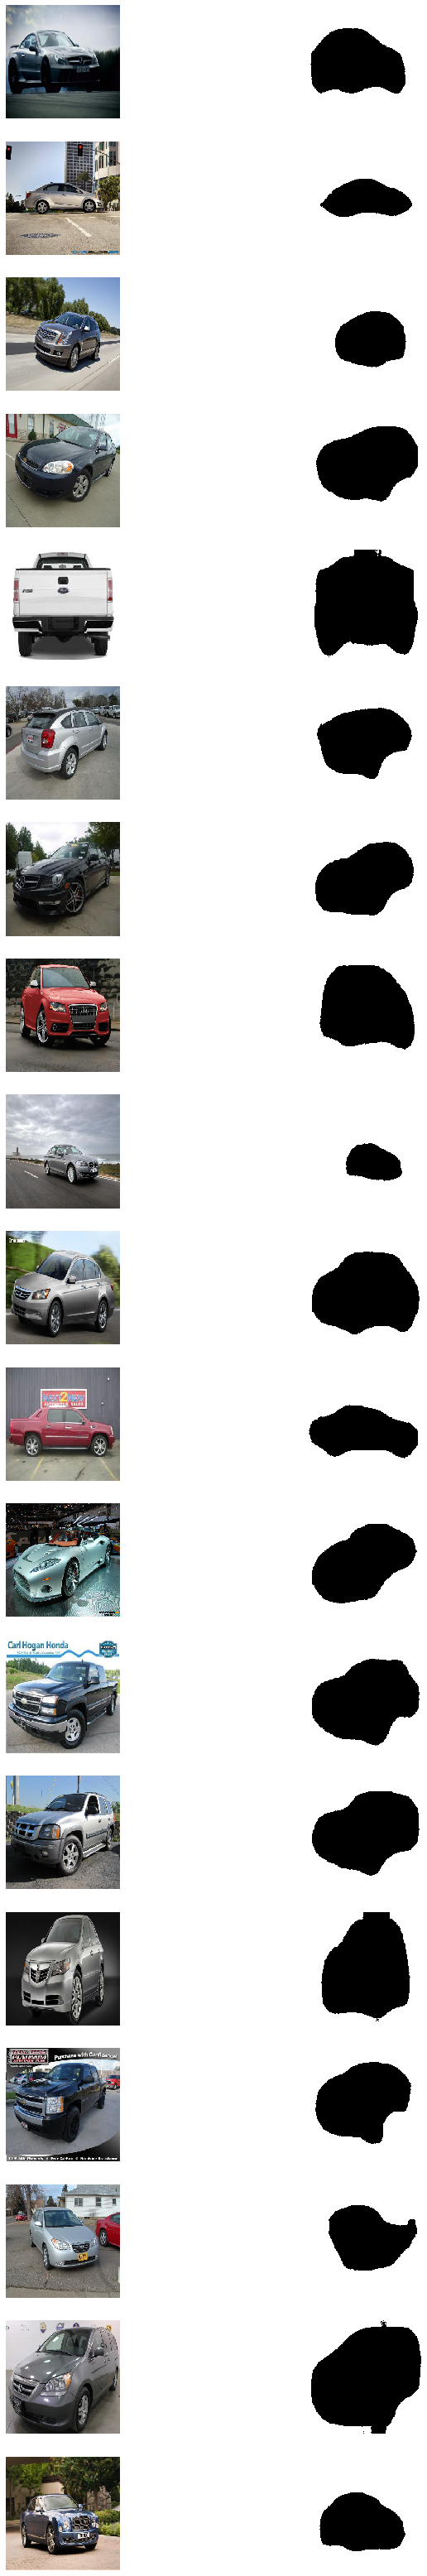

In [42]:
import matplotlib.pyplot as plt
preds = [model.predict(np.expand_dims(x, axis=0))[0].argmax(axis=2) for x in test_x]


n = test_x.shape[0]

plt.figure(figsize=(12, n*3))
for i in range(n):
#     image
    ax = plt.subplot(n, 2, 2*i + 1)
    plt.imshow(test_x_orig[i])
#     plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    
    # segmentation
    ax = plt.subplot(n, 2, 2*i + 2)
    plt.imshow(preds[i])
#    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()
        
        
# plt.imshow(pred)
# plt.imshow(test_x_orig[0])

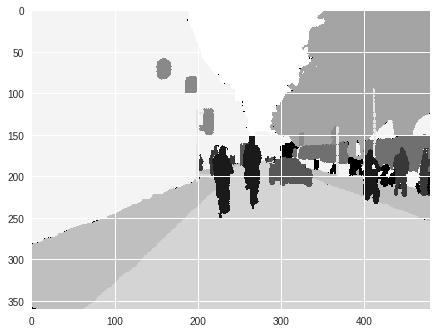

In [0]:
plt.imshow(test_y[0].argmax(axis=2))

## Save a trained model

In [0]:
model_file = 'Michal_Naruniec_360386.h5'

In [0]:
model.save(model_file)
del model

## Load the trained model and evaluate it on the test set
 - the required metric: pixel accuracy
 - additional, for those who want: mean IoU

In [18]:
from keras.models import load_model

del train_x
del train_y

model = load_model(model_file)

OSError: ignored

In [0]:
model.evaluate(test_x, test_y)

101/101 [==============================] - 21s 212ms/step


[0.3458624296259172, 0.8910935119827195]

## Submission
You need to send the well trained model and jupyter notebook (ipynb file) with all outputs as YourFirstName_YourSourname_Indeks.ipynb file by the deadline.

In [0]:
!mv Michal_Naruniec_mn360386.h5.old Michal_Naruniec_mn360386.h5

In [10]:
print(train_x.shape)
print(train_y.shape)

(367, 360, 480, 3)
(367, 360, 480, 12)


In [20]:
import matplotlib.pyplot as plt
import os
import PIL

x = np.array(PIL.Image.open("00001.jpg").resize([480, 360]))

print(x.shape)

#pred = model.predict(np.expand_dims(x, axis=0))[0].argmax(axis=2)
#plt.imshow(pred)



(360, 480, 3)
